### ANN for regression, example 2, house market data (how to handle categorical variables)

### THIS VERSION DEMONSTRATES HOW YOU CAN USE SCALERS AND TRANSFORMATIONS IN DATA (also potential beginner's traps will be mentioned)

Unfortunately, using manual scalers and transformations for a dataset (scikit-learn) will make your machine learning training more complicated, but in some projects it's the necessary thing to do.

#### Imports / modules

In [1]:
# pip install scikit-learn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import metrics

# pip install tensorflow
import tensorflow as tf
import keras
from keras import layers

# you can lock down all random seeds in order 
# to reproduce same results, metrics etc. every time
# this technique is often used in working life in order
# to cut down the random variation between training runs
import os
import random
seed = 869173539
os.environ['PYTHONHASHSEED'] = str(seed)      
random.seed(seed)                             
np.random.seed(seed)                          
tf.random.set_seed(seed) 

#### Loading the dataset

In [2]:
# load the data
df = pd.read_csv("Housing.csv")

### Handling the categorical variables

In [3]:
# WE HAVE SOME BOOLEAN CATEGORIES
# => change them to 0 and 1

# this just converts the value of column to 0 or 1
# factorize in pandas works too, but only one column at a time
from sklearn.preprocessing import LabelEncoder
variables = ['mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'prefarea']
encoder = LabelEncoder()
df[variables] = df[variables].apply(encoder.fit_transform)

### Convert text categories with multiple choices into multiple variables

In [4]:
# create a helper function for pandas and replace
# the different furnishingstatus values into either 0 or 1
def modify_furnishing(row):
    if row['furnishingstatus'] == 'unfurnished':
        return 0
    else:
        return 1
    
# create a new boolean/binary furnished status 
# 0 => not furnished
# 1 => either fully or partially furnished
df['furnished'] = df.apply(modify_furnishing, axis=1)

# drop the original 3-option furnishing status
df = df.drop("furnishingstatus", axis=1)

#### Removing outliers

#### You can also get as fancy you wish with outlier detection and removal

In [5]:
# let's try a fancier example for outlier removal
# this code is originally from:
# https://stackoverflow.com/questions/69248118/detect-outliers-across-all-columns-of-pandas-dataframe

def find_outliers(col):
    q1 = col.quantile(.15)
    q3 = col.quantile(.85)
    IQR = q3 - q1
    ll = q1 - (1.5*IQR)
    ul = q3 + (1.5*IQR)
    upper_outliers = col[col > ul].index.tolist()
    lower_outliers = col[col < ll].index.tolist()
    bad_indices = list(set(upper_outliers + lower_outliers))
    return(bad_indices)

# get indexes of all outliers into a list
bad_indexes = []
for col in df.columns:
    if df[col].dtype in ["int64","float64"]:
        bad_indexes.append(find_outliers(df[col]))


# modify the list so that we can drop these rows from the DataFrame

bad_indexes = set(list(np.concatenate(bad_indexes).flat))

print(len(bad_indexes))

# drop the outliers
df = df.drop(bad_indexes)

145


### X/y -split

In [6]:
# perform X/y -split
# if you  have more than one independent variable, list them all here
# leave out the target variable! (dependent variable)

# this is a nice and common trick => everything EXCEPT target variable => support variable
X = df.drop("price", axis=1)

# have only the target variable here (dependent variable)
y = df["price"]

### Train/test/validation -split

### IF YOU EVER USE DATA SCALING/NORMALIZATION/STANDARDIZATION/TRANSFORMATION instead of neural network layers, ALWAYS DO THESE STEPS AFTER THE TRAIN-TEST -SPLIT

In [7]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, FunctionTransformer, PowerTransformer, QuantileTransformer

# split the dataset into train/test/validation by using the trick we have used
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5)

### Scalers and transformations can be done after train/test -split

There are multiple normalization, standardization, regularization and transformation algorithms available. This example uses MinMaxScaler for support variables nad QuantileTransformer for the target. You can search for more online and experiment with them!

In [8]:
# scalers are always fit (trained) with training data only, DON'T USE TESTING DATA FOR FITTING A SCALER
# because we otherwise we leak information of the correct answers to the model

# transform support variables, change the scaler if you wish!
x_scaler = MinMaxScaler()
x_scaler.fit(X_train)

# transform target variable separately to avoid data leakage
y_scaler = QuantileTransformer(output_distribution='normal', random_state=42)
y_scaler.fit(y_train.values.reshape(-1, 1))

# transform/scale all our support variables in train, validation and test datasets
X_train = x_scaler.transform(X_train)
X_val = x_scaler.transform(X_val)
X_test = x_scaler.transform(X_test)

# transform/scale all our target variables in train, validation and test datasets
# scalers and transformers often require data in NumPy -format
# this is why we need the values.reshape(-1, 1)
y_train = y_scaler.transform(y_train.values.reshape(-1, 1))
y_val = y_scaler.transform(y_val.values.reshape(-1, 1))
y_test  = y_scaler.transform(y_test.values.reshape(-1, 1))

c:\Users\tuomas.valtanen\DL2025lecturenotes2\DeepLearning2025\.venv\Lib\site-packages\sklearn\preprocessing\_data.py:2846: UserWarning: n_quantiles (1000) is greater than the total number of samples (280). n_quantiles is set to n_samples.
  warnings.warn(


#### Create a neural network structure

In [9]:
# create neural network

from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# save the amount of support variables into a helper variable
# so we don't have to update the input_shape all the time
variable_amount = len(X.columns)

# create callbacks and place them into a parameter list
# NOTE! if you get PermissionError while training the model,
# just try training it again
mc = ModelCheckpoint('best_model_regression3_housing_scalers.keras', monitor='val_loss', mode='min', save_best_only=True)

# if you use multiple callbacks (EarlyStoppin, ReduceLROnPlateau etc.)
# add them to this same list
callback_list = [mc]

# Define Sequential neural network model
# input shape has to match the amount of SUPPORT VARIABLES
# in other words => amount of columns in X 

# Tip: have at least the same number of nodes as in the input shape

# since we have 13 support variables this time => 16 nodes in first layer

# output layer in regression is always 1 node without activation function
model = keras.Sequential(
    [
        layers.BatchNormalization(input_shape=(variable_amount,)),
        layers.Dense(24, activation="relu", kernel_regularizer=keras.regularizers.l1_l2(l1=0.105, l2=0.105)),
        layers.Dropout(0.2),
        layers.Dense(16, activation="relu"),
        layers.Dense(12, activation="relu"),
        layers.Dense(1)
    ]
)

# select the optimizer and loss function
# you can try rmsprop also as optimizer, or stochastic gradient descent
# model.compile(optimizer='adam', loss='mse')
# model.compile(optimizer=keras.optimizers.RMSprop(0.00085), loss=keras.losses.Huber())
# model.compile(optimizer=keras.optimizers.SGD(0.001), loss="mse")
# an example where we alter the learning rate of Adam-optimizer
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.00125), loss='mse')

# common tips on how to change neural network structure if your metrics are not good:

# make wider (or narrower) layers (for example, 64 or 128 nodes)
# make a longer or shorter network (add or remove layers)
# use Dropout -layers (e.g. layers.Dropout(0.1))

# remember: there's no process or mathematical formula
# in order to figure out the optimal neural network structure
# it's mostly all about trial and error => EXPERIMENTATION!

# remember to have enough "decision-space" for your data!
# it's highly unlikely a dataset with 20 different variables is going
# to work well with only 8 nodes in each layer etc.

# print out the summary of your model
model.summary()

c:\Users\tuomas.valtanen\DL2025lecturenotes2\DeepLearning2025\.venv\Lib\site-packages\keras\src\layers\normalization\batch_normalization.py:142: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization             │ (None, 12)             │            48 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 24)             │           312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 12)             │           204 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            13 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 977 (3.82 KB)

 Trainable params: 953 (3.72 KB)

 Non-trainable params: 24 (96.00 B)

### Train the neural network

In [10]:
# train/fit neural network with validation data
# see the instructions on the train/test -split above on how to split the data correctly
model.fit(x=X_train, y=y_train, epochs=800, validation_data=(X_val, y_val), callbacks=callback_list)

Epoch 1/800
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 10.6915 - val_loss: 8.6063
Epoch 2/800
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 9.2483 - val_loss: 8.0734
Epoch 3/800
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 8.4269 - val_loss: 7.6287
Epoch 4/800
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 7.8184 - val_loss: 7.2297
Epoch 5/800
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 7.3843 - val_loss: 6.8548
Epoch 6/800
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 6.9815 - val_loss: 6.4960
Epoch 7/800
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 6.5987 - val_loss: 6.1466
Epoch 8/800
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 6.2268 - val_loss: 5.8188
Epoch 9/800
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 5.8698 - val_loss: 5.4956
Epoch 10/800
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 5.5442 - val_loss: 5.1881
Epoch 11/800
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 5.2198 - val_loss: 4.8960
Epoch 12/800
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.9492 - val_l

### Performance and error metrics

<Axes: >

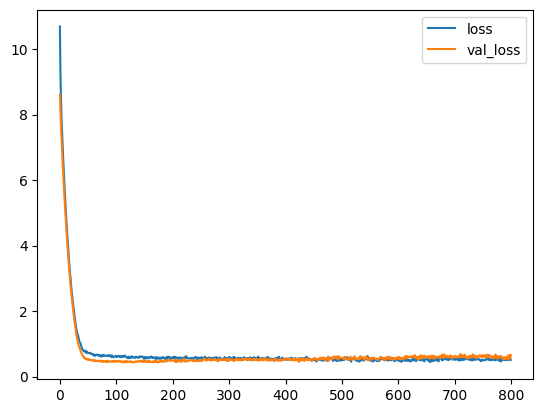

In [11]:
# let's use pandas for this (easy code)
# try to look if the model is actually training 
# => the error is going downwards
# if using validation data, you get two lines
# in this case, see if the lines follow a similar trend 
# (they don't always overlap with complex data, the trend is more important)
loss_df = pd.DataFrame(model.history.history)
loss_df.plot()

### Reload the best version of the model from history

In [12]:
from keras.models import load_model
model = load_model('best_model_regression3_housing_scalers.keras')

In [13]:
# compare the final model loss/evaluation values
print("Test data evaluation:")
print(model.evaluate(X_test, y_test, verbose=0))
print("\nTrain data evaluation:")
print(model.evaluate(X_train, y_train, verbose=0))

Test data evaluation:
0.34819379448890686

Train data evaluation:
0.5689365267753601


### This part is modified so, that the original "test_predictions" is left in the original format (instead of replacing it with pd.Series)

In [14]:
# get test predictions
test_predictions = model.predict(X_test)

# reshape the data for easier comparison table
test_predictions_table = pd.Series(test_predictions.reshape(len(y_test),))
pred_df = pd.DataFrame(np.asarray(y_test), columns=['Test True Y'])
pred_df = pd.concat([pred_df, test_predictions_table], axis=1)
pred_df.columns = ['Test True Y', 'Model Predictions']

# print the comparison table - true values vs. model predicted values
# we can nicely see here how far off our model is in some cases
pred_df.head(10)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


,Test True Y,Model Predictions
0,0.561886,0.462997
1,-0.098989,0.137675
2,-0.839063,-0.778505
3,0.194380,0.941646
4,2.313250,1.342133
5,-1.321364,-1.454918
6,-0.795155,-1.272151
7,-1.109524,-0.531795
8,0.705841,-0.045912
9,-0.111637,-0.015867


<Axes: xlabel='Test True Y', ylabel='Model Predictions'>

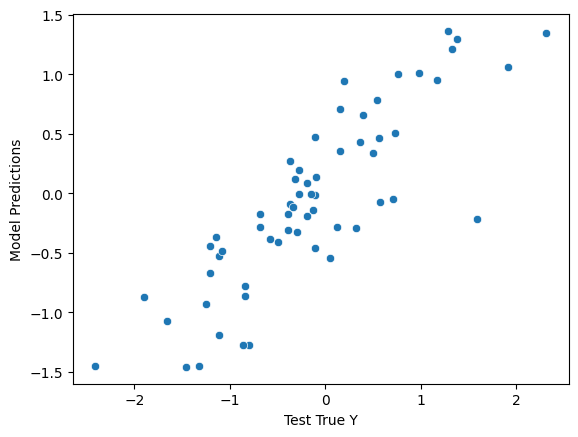

In [15]:
# these values follow a linear diagonal line = good predictions
# we basically compare the predicted values 
# to true test values and see the differences
sns.scatterplot(x='Test True Y', y='Model Predictions', data=pred_df)

### The metrics have been modified as well so that we have a reference point in actual units (dollars) to see how much the scaled metrics are off currently

NOTE! The metrics are also scaled since we used scalers/transformations after the train/test/validation split!

In order to reverse the scaled value, we re-use the scalers to perform INVERSE TRANSFORM

In [16]:
# MAE - Mean average error
print("MAE")
print(round(metrics.mean_absolute_error(y_test, test_predictions_table), 2), "units (% in decimals if using MinMaxScaler, kind of)")

# MSE - Mean square error
print("\nMSE")
print(round(metrics.mean_squared_error(y_test, test_predictions), 2), "units^2")

# RMSE - Root mean square error
print('\nRMSE:')
print(round(np.sqrt(metrics.mean_squared_error(y_test, test_predictions_table)), 2), "units")

# we need the original values in order to calculate RMSE with actual units
# inverse transform is once again very useful here
# reshape(-1, 1) is used to convert the data to required format for inverse_transform
y_test_orig = y_scaler.inverse_transform(np.array(y_test).reshape(-1, 1))
test_predictions_orig = y_scaler.inverse_transform(test_predictions.reshape(-1, 1))

# Now compute RMSE in original units
rmse = np.sqrt(metrics.mean_squared_error(y_test_orig, test_predictions_orig))
print(f'\nRMSE (original units):\n{rmse:.2f} $')

# R-squared. 0 = the model descibes the dataset poorly
# 1 = model describes the datas'et perfectly
print('\nR-squared:')
print(round(metrics.r2_score(y_test, test_predictions), 2))

# Explained Variance Score => 0 = the model descibes the dataset poorly
# 1 = model describes the dataset perfectly
# high variance score = model is a good fit for the data 
# low variance score = model is not a good fit for the data
# the higher the score, the model is more able to explain the variation in the data
# if score is low, we might need more and better data
print("\nExplained variance score:")
print(round(metrics.explained_variance_score(y_test, test_predictions), 2))

MAE
0.38 units (% in decimals if using MinMaxScaler, kind of)

MSE
0.25 units^2

RMSE:
0.5 units

RMSE (original units):
823410.29 $

R-squared:
0.71

Explained variance score:
0.72


C:\Users\tuomas.valtanen\AppData\Local\Temp\ipykernel_14196\3124900743.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot((y_test - test_predictions))


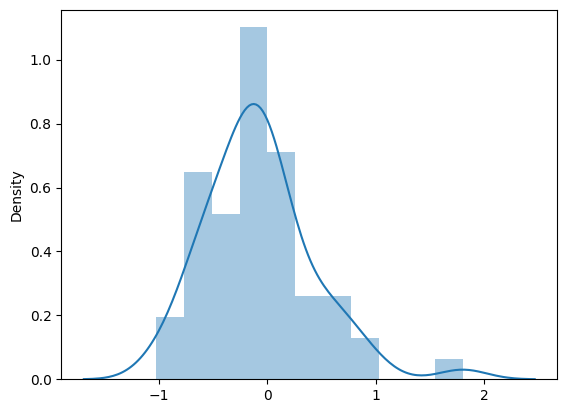

In [17]:
# if the prediction distribution are far from normal distribution
# then the model is not probably good enough
# distplot is deprecating in future pandas-version
# unfortunately, there's no exact alternative to do this plot at the moment
sns.distplot((y_test - test_predictions))
plt.show()
plt.close()

#### Trying the model in practice with new imaginary house

In [18]:
# just to see what kind of values are usually in the dataset
# so we can test with the tester_row
df.head(3)

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnished
4,11410000,7420,4,1,2,1,1,1,0,1,2,0,1
5,10850000,7500,3,3,1,1,0,1,0,1,2,1,1
8,9870000,8100,4,1,2,1,1,1,0,1,2,1,1


### TODO: fix the code below

In [19]:
# let's try with some new imaginary data
# this example uses the student performance index score dataset
# modify this as needed regarding your own dataset
tester_row = {
    'area': 7420, 
    'bedrooms': 4, 
    'bathrooms': 2, 
    'stories': 3, 
    'mainroad': 1,
    'guestroom': 0, 
    'basement': 0, 
    'hotwaterheating': 0, 
    'airconditioning': 1,
    'parking': 2,
    'prefarea': 1,
    'furnished': 1,
}

# convert to pandas-format
tester_row = pd.DataFrame([tester_row])

# scale our tester row with original x-scaler (support variable scaler)
tester_row = x_scaler.transform(tester_row)

In [20]:
# make a prediction and save the scaled result back into the tester_row
result = model.predict(tester_row)

# inverse the scaling back to original unit (dollars in this case)
result = y_scaler.inverse_transform(result.reshape(-1, 1))[0]

print()
print(f"Predicted price with given apartment parameters:")
print(f"{round(float(result[0]), 2)} $")
print("----------------")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step

Predicted price with given apartment parameters:
8095444.5 $
----------------
